# Analysing Results

In [1]:
import gzip

from pprint import pprint

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from deephyper.analysis import rank
from deephyper.analysis._matplotlib import figure_size, update_matplotlib_rc

from lcdb.analysis import read_csv_results
from lcdb.analysis.plot import plot_learning_curves


update_matplotlib_rc()
figsize = figure_size(252 * 1.8, 1.0)

In [3]:
source_csv = "output/lcdb.workflow.keras.DenseNNWorkflow/3/42-42-42/results.csv.gz"

# Load a dataframe with the results
# The dataframe is sorted by `job_id` (increasing) as parallel jobs scheduled asynchronously 
# may be collected in a different order than when they were submitted.
with gzip.GzipFile(source_csv, "rb") as f:        
    r_df, r_df_failed = read_csv_results(f)
r_df

,p:activation,p:activity_regularizer,p:batch_norm,p:batch_size,p:bias_regularizer,p:dropout_rate,p:kernel_initializer,p:kernel_regularizer,p:learning_rate,p:num_layers,...,m:openmlid,m:workflow_seed,m:workflow,m:valid_prop,m:test_prop,m:monotonic,m:valid_seed,m:test_seed,m:traceback,m:json
3,relu,none,False,32,none,0.100000,glorot_uniform,none,0.001000,5,...,3,42,lcdb.workflow.keras.DenseNNWorkflow,0.1,0.1,True,42,42,NaN,"{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
49,selu,L2,False,2,L2,0.767123,random_uniform,none,0.000773,7,...,3,42,lcdb.workflow.keras.DenseNNWorkflow,0.1,0.1,True,42,42,"""Traceback (most recent call last):\n File ""/...","{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
29,softmax,none,True,14,L1L2,0.547903,ones,L2,0.000048,2,...,3,42,lcdb.workflow.keras.DenseNNWorkflow,0.1,0.1,True,42,42,NaN,"{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
27,selu,L1,False,15,L1L2,0.825365,ones,L1L2,0.000538,16,...,3,42,lcdb.workflow.keras.DenseNNWorkflow,0.1,0.1,True,42,42,NaN,"{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
9,softmax,L2,True,231,none,0.524551,zeros,L1L2,0.000140,19,...,3,42,lcdb.workflow.keras.DenseNNWorkflow,0.1,0.1,True,42,42,NaN,"{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,softmax,L1L2,True,255,L1L2,0.273405,ones,L1,1.227268,8,...,3,42,lcdb.workflow.keras.DenseNNWorkflow,0.1,0.1,True,42,42,NaN,"{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
90,softsign,L2,False,399,L1L2,0.508246,he_normal,L1L2,0.000047,16,...,3,42,lcdb.workflow.keras.DenseNNWorkflow,0.1,0.1,True,42,42,NaN,"{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
93,softplus,L2,False,186,L1L2,0.732397,zeros,L1,0.001313,10,...,3,42,lcdb.workflow.keras.DenseNNWorkflow,0.1,0.1,True,42,42,NaN,"{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
88,softmax,L1L2,False,64,L1,0.769191,random_normal,L2,0.032845,8,...,3,42,lcdb.workflow.keras.DenseNNWorkflow,0.1,0.1,True,42,42,NaN,"{'tag': 'run', 'timestamp_start': 0.0, 'timest..."


In [4]:
r_df_failed

,p:activation,p:activity_regularizer,p:batch_norm,p:batch_size,p:bias_regularizer,p:dropout_rate,p:kernel_initializer,p:kernel_regularizer,p:learning_rate,p:num_layers,...,m:openmlid,m:workflow_seed,m:workflow,m:valid_prop,m:test_prop,m:monotonic,m:valid_seed,m:test_seed,m:traceback,m:json
5,exponential,none,True,6,none,0.899634,he_normal,L1L2,0.003501,19,...,3,42,lcdb.workflow.keras.DenseNNWorkflow,0.1,0.1,True,42,42,"""Traceback (most recent call last):\n File ""/...","{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
8,exponential,L1L2,True,134,L2,0.087532,he_normal,none,0.074400,12,...,3,42,lcdb.workflow.keras.DenseNNWorkflow,0.1,0.1,True,42,42,"""Traceback (most recent call last):\n File ""/...","{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
17,exponential,none,False,90,L1L2,0.384576,glorot_uniform,none,0.013054,5,...,3,42,lcdb.workflow.keras.DenseNNWorkflow,0.1,0.1,True,42,42,"""Traceback (most recent call last):\n File ""/...","{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
25,exponential,L1L2,True,73,L1,0.436133,he_normal,none,0.025815,2,...,3,42,lcdb.workflow.keras.DenseNNWorkflow,0.1,0.1,True,42,42,"""Traceback (most recent call last):\n File ""/...","{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
26,exponential,L2,False,442,L2,0.367751,orthogonal,L1,0.000022,5,...,3,42,lcdb.workflow.keras.DenseNNWorkflow,0.1,0.1,True,42,42,"""Traceback (most recent call last):\n File ""/...","{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
32,softplus,L1L2,True,3,L1L2,0.812288,variance_scaling,none,0.006421,10,...,3,42,lcdb.workflow.keras.DenseNNWorkflow,0.1,0.1,True,42,42,"""Traceback (most recent call last):\n File ""/...","{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
38,exponential,L1,True,372,none,0.581890,he_normal,L1,0.099240,17,...,3,42,lcdb.workflow.keras.DenseNNWorkflow,0.1,0.1,True,42,42,"""Traceback (most recent call last):\n File ""/...","{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
67,exponential,L1,False,177,L1L2,0.143879,he_normal,L2,0.012345,12,...,3,42,lcdb.workflow.keras.DenseNNWorkflow,0.1,0.1,True,42,42,"""Traceback (most recent call last):\n File ""/...","{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
70,elu,L2,False,74,L2,0.870235,zeros,none,4.623147,13,...,3,42,lcdb.workflow.keras.DenseNNWorkflow,0.1,0.1,True,42,42,"""Traceback (most recent call last):\n File ""/...","{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
78,none,none,False,2,L1L2,0.757540,random_normal,L2,0.468204,16,...,3,42,lcdb.workflow.keras.DenseNNWorkflow,0.1,0.1,True,42,42,"""Traceback (most recent call last):\n File ""/...","{'tag': 'run', 'timestamp_start': 0.0, 'timest..."


In [5]:
timestamp_start_experiment = min(r_df["m:timestamp_submit"].min(), r_df_failed["m:timestamp_submit"].min())
timestamp_end_experiement = min(r_df["m:timestamp_gather"].max(), r_df_failed["m:timestamp_gather"].max())
duration_experiment = timestamp_end_experiement - timestamp_start_experiment
print(f"Experiment duration: {duration_experiment} seconds")

Experiment duration: 2729.9605095386505 seconds


In [8]:
# Display the error of a failed job
idx = 0
print(r_df_failed.iloc[idx]["m:traceback"])

"Traceback (most recent call last):
  File "/lus/grand/projects/datascience/regele/polaris/lcdb/publications/2023-neurips/lcdb/controller.py", line 208, in fit_workflow_on_current_anchor
    self.workflow.fit(
  File "/lus/grand/projects/datascience/regele/polaris/lcdb/publications/2023-neurips/lcdb/utils.py", line 67, in terminate_on_timeout
    return results.get(timeout)
  File "/lus/grand/projects/datascience/regele/polaris/lcdb/publications/2023-neurips/build/dhenv/lib/python3.10/multiprocessing/pool.py", line 774, in get
    raise self._value
  File "/lus/grand/projects/datascience/regele/polaris/lcdb/publications/2023-neurips/build/dhenv/lib/python3.10/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/lus/grand/projects/datascience/regele/polaris/lcdb/publications/2023-neurips/lcdb/workflow/_base_workflow.py", line 31, in fit
    self._fit(X=X, y=y, metadata=metadata, *args, **kwargs)
  File "/lus/grand/projects/datascience/regele/po

In [9]:
# Pre-made queries from LCDB
from lcdb.analysis.json import JsonQuery
from lcdb.analysis.json import QueryAnchorValues, QueryMetricValuesFromAnchors
from lcdb.analysis.json import QueryEpochValues, QueryMetricValuesFromEpochs
from lcdb.analysis.score import accuracy_from_confusion_matrix

In [10]:
source = r_df["m:json"]

query_anchor_values = QueryAnchorValues()
anchor_values = source.apply(query_anchor_values).to_list()

query_confusion_matrix_values = QueryMetricValuesFromAnchors("confusion_matrix", split_name="val")
out = source.apply(query_confusion_matrix_values)
accuracy_values = out.apply(lambda x: list(map(accuracy_from_confusion_matrix, x))).to_list()

for i, (xi, yi) in enumerate(zip(anchor_values, accuracy_values)):
    anchor_values[i] = xi[:len(yi)]

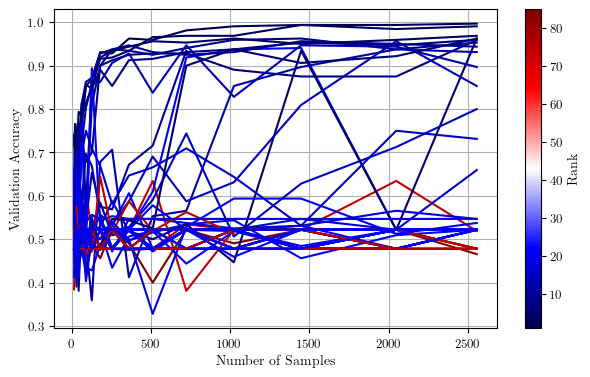

In [11]:
fig, ax = plt.subplots(figsize=figsize)
plot_learning_curves(anchor_values, accuracy_values, ax=ax)
ax.set_xlabel(f"Number of Samples")
ax.set_ylabel(f"Validation Accuracy")
plt.show()

In [13]:
source = r_df["m:json"]

# Query All Epochs and Keep Only Last Anchor
query_epoch_values = QueryEpochValues()
epoch_values = source.apply(lambda x: query_epoch_values(x)[-1]).to_list()

query_confusion_matrix_values = QueryMetricValuesFromEpochs(
    "confusion_matrix", split_name="val"
)
out = source.apply(lambda x: query_confusion_matrix_values(x)[-1])
accuracy_values = out.apply(
    lambda x: list(map(accuracy_from_confusion_matrix, x))
).to_list()

# Remove experiments which ended up with "NaN"
epoch_values, accuracy_values = list(
    zip(
        *[
            (xi, yi)
            for xi, yi in zip(epoch_values, accuracy_values)
            if len(xi) == len(yi)
        ]
    )
)

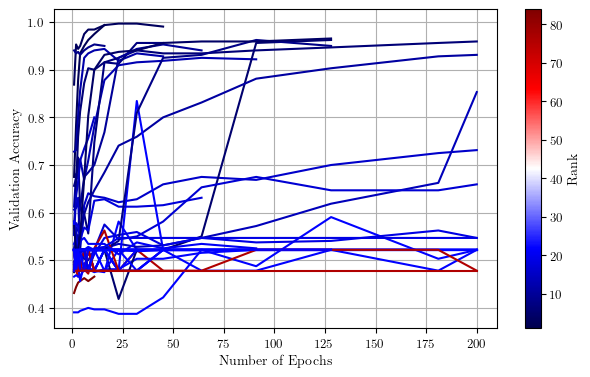

In [14]:
fig, ax = plt.subplots(figsize=figsize)
plot_learning_curves(epoch_values, accuracy_values, ax=ax)
ax.set_xlabel(f"Number of Epochs")
ax.set_ylabel(f"Validation Accuracy")
plt.show()

In [19]:
x = [xi[-1] for xi in accuracy_values]
sorted(x)

[0.465625,
 0.478125,
 0.478125,
 0.478125,
 0.478125,
 0.478125,
 0.478125,
 0.478125,
 0.478125,
 0.51875,
 0.521875,
 0.521875,
 0.521875,
 0.521875,
 0.521875,
 0.521875,
 0.521875,
 0.521875,
 0.521875,
 0.521875,
 0.521875,
 0.521875,
 0.521875,
 0.521875,
 0.521875,
 0.521875,
 0.521875,
 0.521875,
 0.521875,
 0.521875,
 0.521875,
 0.521875,
 0.521875,
 0.521875,
 0.521875,
 0.521875,
 0.521875,
 0.521875,
 0.521875,
 0.521875,
 0.521875,
 0.521875,
 0.521875,
 0.521875,
 0.521875,
 0.521875,
 0.521875,
 0.521875,
 0.521875,
 0.521875,
 0.521875,
 0.521875,
 0.521875,
 0.521875,
 0.521875,
 0.521875,
 0.521875,
 0.521875,
 0.521875,
 0.521875,
 0.521875,
 0.521875,
 0.521875,
 0.521875,
 0.525,
 0.546875,
 0.546875,
 0.63125,
 0.659375,
 0.73125,
 0.8,
 0.853125,
 0.921875,
 0.928125,
 0.93125,
 0.940625,
 0.95,
 0.95,
 0.95625,
 0.959375,
 0.9625,
 0.965625,
 0.990625,
 0.99375]